Exercício - Dataset Diabetes usando MLFlow
==========================================

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf

from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import KMeansSMOTE
from xgboost import plot_importance

import mlflow
import mlflow.keras
import mlflow.sklearn

import sys
from datetime import datetime

sys.path.insert(1, '../')

from src.plot import plot_heatmap
from src.train import get_all_subsets, results_regression

import warnings
warnings.filterwarnings("ignore")

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



2023-11-11 15:02:27.353811: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 15:02:27.353839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 15:02:27.353864: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 15:02:27.362205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

2023-11-11 15:02:30.327134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
sns.set_style('darkgrid')
PLOT_MEDIUM = (10,6)

## Load dataset

In [4]:
data = pd.read_csv('./../../../Datasets/diabetes.csv')
display(data.shape, data.head())

(768, 9)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Pre processing

In [5]:
# Missing values
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
# duplicates
data.duplicated().sum()

0

In [7]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

## EDA

In [8]:
data_correlation = data.corr()
data_correlation.style.background_gradient(cmap='viridis')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


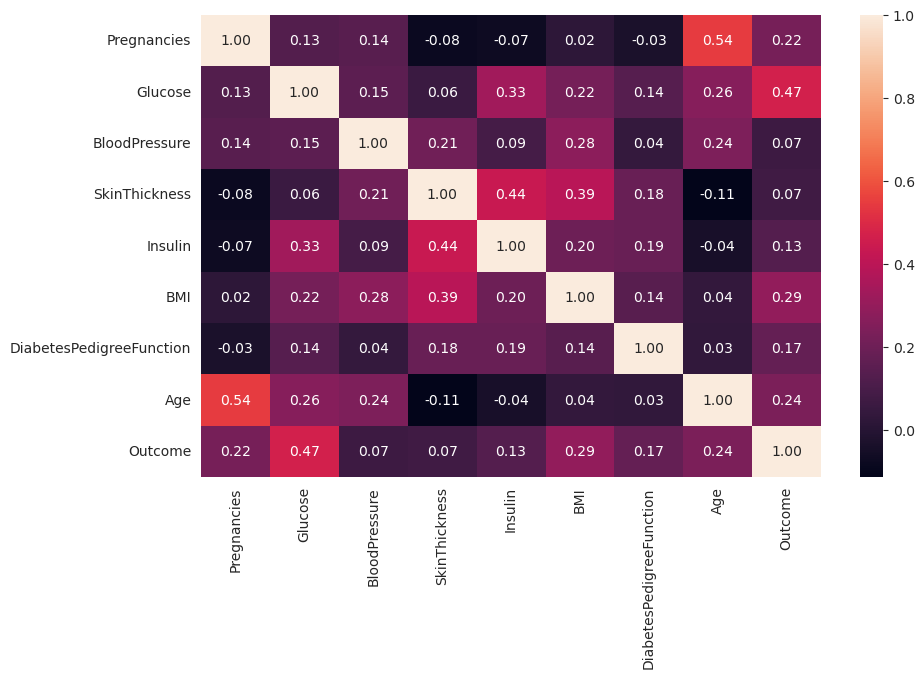

In [9]:
plt.figure(figsize=PLOT_MEDIUM)
sns.heatmap(data_correlation, annot=True, fmt='.2f')
plt.show()

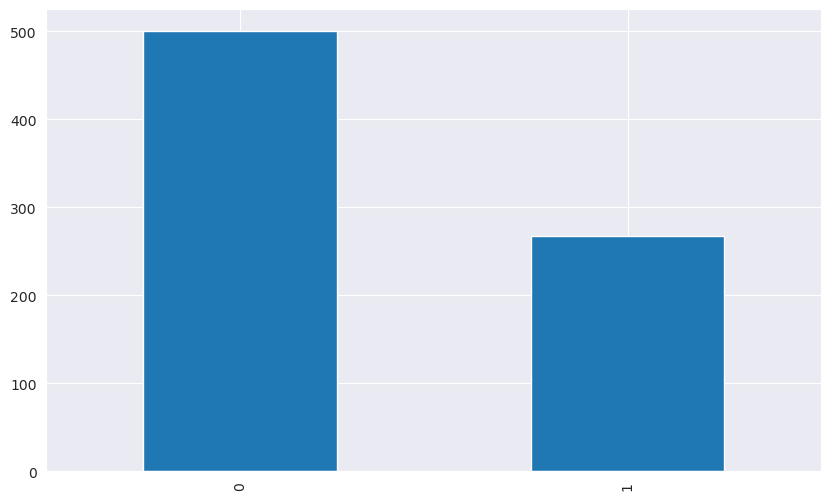

In [10]:
plt.figure(figsize=PLOT_MEDIUM)
data.Outcome.value_counts().plot(kind='bar')
plt.show()

## Split dataset

In [11]:
# get X and y vars
y = data['Outcome']
X = data.drop('Outcome', axis=1)

In [12]:
# Balance vars
sm = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)
X, y = sm.fit_resample(X, y)

# Check
y.value_counts()

1    502
0    500
Name: Outcome, dtype: int64

In [13]:
# Normalize
y /= np.max(y)
X /= np.max(X, axis=0)

In [14]:
# Get train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0 ,test_size=0.2)

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)


X_train:  (801, 8)
X_test:  (201, 8)
y_train:  (801,)
y_test:  (201,)


## MLOps

In [15]:
# Informando dataset no mlflow
mlflow_dataset = mlflow.data.from_pandas(data, \
                                         source="datasets_diabetes.csv", 
                                         name="Diabetes Dataset")

### Keras

In [16]:
RELU = 'relu'
SIGMOID = 'sigmoid'

n_seeds = 2
n_neurons = 256
batch_size = 8
epochs = 30
random_state = 42

mlflow.set_experiment("Exercicio_Keras_Grupo_Ivandro_Pablo")

with mlflow.start_run():

    # Set mlflow
    mlflow.set_tag("mlflow.runName", "Keras: " + str(datetime.now()))
    mlflow.log_input(mlflow_dataset)
    mlflow.log_param("n_seeds", n_seeds)
    mlflow.log_param("n_neurons", n_neurons)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("random_state", random_state)

    ## Config model
    tf.random.set_seed(n_seeds)
    
    es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

    new_train_x, x_val, new_train_y, y_val = train_test_split(X_train, y_train, 
                                                              test_size = 0.2, 
                                                              random_state = random_state)

    NN_model = Sequential([
        Dense(n_neurons, activation = RELU, input_shape=(X_train.shape[1],)),
        Dense(n_neurons, activation = RELU),
        Dense(n_neurons, activation = RELU),
        Dense(1, activation = SIGMOID)
    ])
    
    NN_model.compile(
        loss='binary_crossentropy',
        optimizer='adamax',
        metrics=['accuracy']
    )
    
    
    train_history = NN_model.fit(new_train_x, new_train_y,
        validation_data=(x_val, y_val),
        batch_size = batch_size,
        shuffle=True,
        epochs = epochs,
        verbose = 1,
        callbacks = [es]
    )

    # Set model
    mlflow.keras.log_model(NN_model, "Keras_Model")
    
    pred_es = NN_model.predict(X_test)
    y_pred = [np.round(i[0]) for i in pred_es]
    results = NN_model.evaluate(X_test, y_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print('Acurácia:' + str(accuracy))
    mlflow.log_metric("accuracy", accuracy)
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot()
    
    plt.savefig("confusion_diabetes.png")
    plt.close()

    mlflow.log_artifact("confusion_diabetes.png")

mlflow.end_run()

Epoch 1/30
80/80 [==============================] - 1s 6ms/step - loss: 0.6563 - accuracy: 0.6172 - val_loss: 0.6385 - val_accuracy: 0.6646
Epoch 2/30
80/80 [==============================] - 0s 4ms/step - loss: 0.5860 - accuracy: 0.7109 - val_loss: 0.5610 - val_accuracy: 0.7205
Epoch 3/30
80/80 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.7234 - val_loss: 0.5361 - val_accuracy: 0.7267
Epoch 4/30
80/80 [==============================] - 0s 4ms/step - loss: 0.5313 - accuracy: 0.7422 - val_loss: 0.5287 - val_accuracy: 0.7329
Epoch 5/30
80/80 [==============================] - 0s 4ms/step - loss: 0.5144 - accuracy: 0.7516 - val_loss: 0.4925 - val_accuracy: 0.7702
Epoch 6/30
80/80 [==============================] - 0s 4ms/step - loss: 0.4918 - accuracy: 0.7641 - val_loss: 0.5032 - val_accuracy: 0.7516
Epoch 7/30
80/80 [==============================] - 0s 4ms/step - loss: 0.4802 - accuracy: 0.7609 - val_loss: 0.4584 - val_accuracy: 0.8012
Epoch 8/30
80/80 [==

2023/11/11 15:02:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp9capy6zo/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp9capy6zo/model/data/model/assets


7/7 [==============================] - 0s 2ms/step - loss: 0.3303 - accuracy: 0.8756
Acurácia:0.8756218905472637
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88       100
         1.0       0.93      0.81      0.87       101

    accuracy                           0.88       201
   macro avg       0.88      0.88      0.88       201
weighted avg       0.88      0.88      0.88       201



### Random Forest

In [17]:
mlflow.set_experiment("Exercicio_Keras_Grupo_Ivandro_Pablo")

n_estimators = 100


with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "Random Forest: " + str(datetime.now()))
    mlflow.log_input(mlflow_dataset)
    
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("random_state", random_state)


    model_rf = RandomForestClassifier(n_estimators = n_estimators, \
                                      random_state = random_state)
    
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)
    
    # modelo
    
    mlflow.sklearn.log_model(model_rf, "Random_Forest")
    
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print('Acurácia:' + str(accuracy))
    
    mlflow.log_metric("accuracy", accuracy)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot()

    plt.savefig("confusion_rf_diabetes.png")
    plt.close()

    mlflow.log_artifact("confusion_rf_diabetes.png")

mlflow.end_run()

2023/11/11 15:02:51 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Acurácia:0.89
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       100
         1.0       0.89      0.88      0.89       101

    accuracy                           0.89       201
   macro avg       0.89      0.89      0.89       201
weighted avg       0.89      0.89      0.89       201



## Requisições

### Keras
`mlflow models serve -m runs:/c16b9c1042a247299953d5092a81d609/Keras_Model --port=5002 --env-manager local`

In [18]:
import requests
import json

In [19]:
# Get sample from dataframe to teste a resquest
data = pd.read_csv('./../../../Datasets/diabetes.csv')
sample_data = data.sample(1)

In [20]:
# getting sample from dataset (just to test)
dados_dict = {
    'columns': sample_data.columns.tolist()[:-1],
    'data': [sample_data.iloc[0,:-1].values.tolist()]
}

dataframe_split = {'dataframe_split': dados_dict}
dataframe_split

{'dataframe_split': {'columns': ['Pregnancies',
   'Glucose',
   'BloodPressure',
   'SkinThickness',
   'Insulin',
   'BMI',
   'DiabetesPedigreeFunction',
   'Age'],
  'data': [[0.0, 104.0, 64.0, 23.0, 116.0, 27.8, 0.454, 23.0]]}}

In [21]:
dados_json = json.dumps(dataframe_split)
dados_json

'{"dataframe_split": {"columns": ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"], "data": [[0.0, 104.0, 64.0, 23.0, 116.0, 27.8, 0.454, 23.0]]}}'

In [23]:
pred = requests.post(url='http://localhost:5002/invocations', 
                         headers={'Content-Type' : 'application/json', }, 
                         data=dados_json)

In [24]:
pred.text

'{"predictions": [{"0": 1.0}]}'

### Random Forest
`mlflow models serve -m runs:/d87ab38c67434d019991c0946f29b8c3/"Random_Forest"  --port=5001 --env-manager local`

In [25]:
pred = requests.post(url='http://localhost:5001/invocations', 
                         headers={'Content-Type' : 'application/json' , }, data=dados_json)

In [26]:
pred.text

'{"predictions": [1.0]}'